I have utilized synthetic datasets generated to demonstrate the optimization and training processes for integrating multiple omics datasets along with pharmacology data. I strongly recommend that you review the attached links for the actual datasets used in my study:

In [ ]:
https://cellmodelpassports.sanger.ac.uk/downloads
https://cog.sanger.ac.uk/cmp/download/model_list_20241120.csv


In [ ]:
Cell annotations

https://cog.sanger.ac.uk/cmp/download/gene_identifiers_20191101.csv
https://cog.sanger.ac.uk/cmp/download/driver_genes_20221018.csv
https://cog.sanger.ac.uk/cmp/download/driver_mutations_20221208.csv
https://cog.sanger.ac.uk/cmp/download/cancer_predisposition_variants_20221208.csv

In [ ]:
Driver Mutations

https://cog.sanger.ac.uk/cmp/download/mutations_summary_20230202.zip
https://cog.sanger.ac.uk/cmp/download/mutations_all_20230202.zip


In [ ]:
RNA Seq Data

https://cog.sanger.ac.uk/cmp/download/rnaseq_all_20220624.zip

In [ ]:
COPY NUMBER ALTERATION DATA

https://cog.sanger.ac.uk/cmp/download/cnv_summary_20230303.zip


In [ ]:
CRISPR KO DATA

https://score.depmap.sanger.ac.uk/downloads

In [ ]:
FUSION PROTEIN DATA

https://cog.sanger.ac.uk/cmp/download/Fusions_20230725.zip

In [ ]:
PROTEIN EXP DATA

https://cog.sanger.ac.uk/cmp/download/Proteomics_20221214.zip

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, boxcox, yeojohnson
from sklearn.preprocessing import StandardScaler
from MultiColumnLabelEncoder import MultiColumnLabelEncoder

def preprocess_multi_omics_datasets(transcriptomics_df, proteomics_df, fusion_protein_df, cn_alteration_df):
    """
    Preprocess multiple omics datasets for drug discovery and model development.
    
    Parameters:
    transcriptomics_df (DataFrame): Transcriptomics dataset.
    proteomics_df (DataFrame): Proteomics dataset.
    fusion_protein_df (DataFrame): Fusion Protein dataset.
    cn_alteration_df (DataFrame): Copy number alteration dataset.
    mutation_df (DataFrame): Mutation dataset.
    
    Returns:
    tuple: Preprocessed DataFrames for each omics dataset.
    """
    
    def preprocess_single_dataset(df, dataset_name):
        """
        Preprocess a single omics dataset.
        
        Parameters:
        df (DataFrame): Input dataset.
        dataset_name (str): Name of the dataset.
        
        Returns:
        DataFrame: Preprocessed dataset.
        """
        
        print(f"Preprocessing {dataset_name} dataset...")
        
        # Handling missing values
        print(f"Handling missing values for {dataset_name} dataset...")
        def fill_null_with_mean(df):
            df.fillna(df.mean(), inplace=True)
            df.fillna(0, inplace=True)
        
        fill_null_with_mean(df)
        
        # Encoding categorical variables
        print(f"Encoding categorical variables for {dataset_name} dataset...")
        mcle = MultiColumnLabelEncoder()
        df = mcle.fit_transform(df)
        
        # Identifying skewness
        print(f"Identifying skewness for {dataset_name} dataset...")
        skewness_values = np.apply_along_axis(skew, axis=0, arr=df)
        plt.hist(x=skewness_values)
        plt.title(f'Skewness Distribution for {dataset_name}')
        plt.show()

        # Identifying kurtosis
        print(f"Identifying kurtosis for {dataset_name} dataset...")
        kurtosis_values = np.apply_along_axis(kurtosis, axis=0, arr=df)
        plt.hist(x=kurtosis_values)
        plt.title(f'Kurtosis Distribution for {dataset_name}')
        plt.show()

        # Transforming columns to reduce skewness and kurtosis
        print(f"Transforming columns to reduce skewness and kurtosis for {dataset_name} dataset...")
        start_column = 12  # Adjust as per your dataset
        
        X = df.iloc[:, start_column:]
        kurtosis_threshold = 3
        
        for i, kurt in enumerate(kurtosis_values[start_column:]):
            col_index = start_column + i
            if kurt > kurtosis_threshold:
                try:
                    transformed_column, _ = boxcox(X.iloc[:, i] + 1)
                    X.iloc[:, i] = transformed_column
                except ValueError:
                    transformed_column, _ = yeojohnson(X.iloc[:, i] + 1)
                    X.iloc[:, i] = transformed_column
            elif kurt < kurtosis_threshold:
                if np.min(X.iloc[:, i]) >= 0:
                    X.iloc[:, i] = np.sqrt(X.iloc[:, i])
                else:
                    X.iloc[:, i] = np.log(X.iloc[:, i] - np.min(X.iloc[:, i]) + 1)
        
        df.iloc[:, start_column:] = X
        
        print(f"Preprocessing for {dataset_name} dataset complete.")
        return df
    
    # Process each dataset
    processed_transcriptomics = preprocess_single_dataset(transcriptomics_df, "Transcriptomics")
    processed_proteomics = preprocess_single_dataset(proteomics_df, "Proteomics")
    processed_fusion_protein = preprocess_single_dataset(fusion_protein_df, "Fusion Protein")
    processed_cn_alteration = preprocess_single_dataset(cn_alteration_df, "Copy Number Alteration")

    
    print("Data preprocessing for all datasets complete.")
    
    return (processed_transcriptomics, processed_proteomics, processed_fusion_protein, processed_cn_alteration)

# Example usage
if __name__ == "__main__":
    # Load your datasets here, replace with actual dataset loading code
    transcriptomics_df = pd.DataFrame()  # Replace with actual data loading
    proteomics_df = pd.DataFrame()  # Replace with actual data loading
    fusion_protein_df = pd.DataFrame()  # Replace with actual data loading
    cn_alteration_df = pd.DataFrame()  # Replace with actual data loading


The following code is designed to generate synthetic datasets for transcriptomics,
genomics, and proteomics. It also demonstrates the functionality of the preprocessing
function. Please refer to the attached repository URL to download the actual dataset,
which you can use to replace the synthetic dataset for the preprocessing steps.

Preprocessing Transcriptomics dataset...
Handling missing values for Transcriptomics dataset...
Encoding categorical variables for Transcriptomics dataset...
Identifying skewness for Transcriptomics dataset...


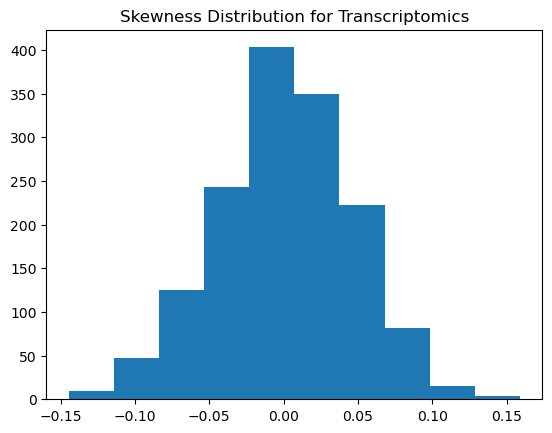

Identifying kurtosis for Transcriptomics dataset...


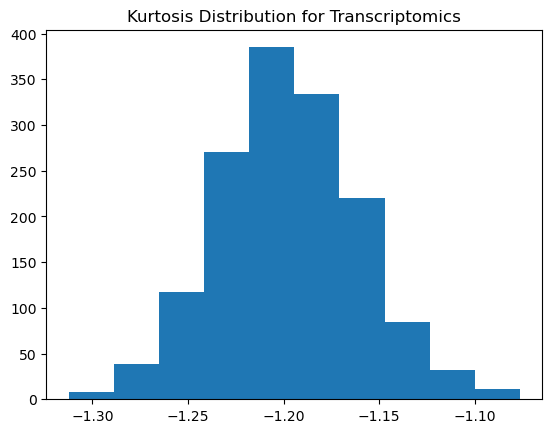

Transforming columns to reduce skewness and kurtosis for Transcriptomics dataset...
Preprocessing for Transcriptomics dataset complete.
Preprocessing Proteomics dataset...
Handling missing values for Proteomics dataset...
Encoding categorical variables for Proteomics dataset...
Identifying skewness for Proteomics dataset...


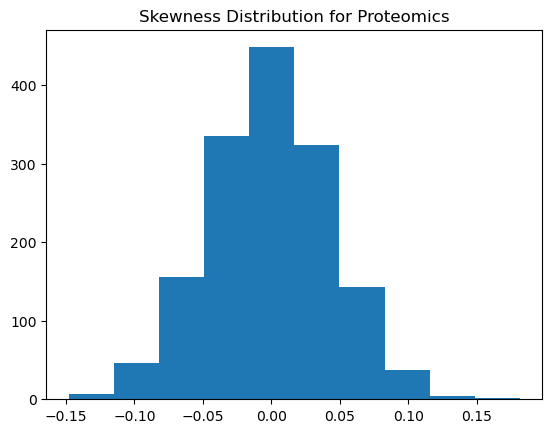

Identifying kurtosis for Proteomics dataset...


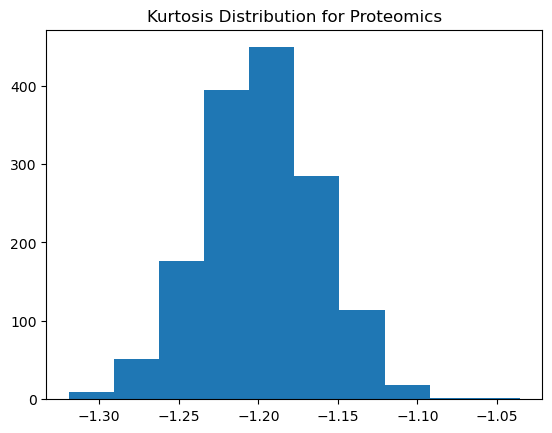

Transforming columns to reduce skewness and kurtosis for Proteomics dataset...
Preprocessing for Proteomics dataset complete.
Preprocessing Fusion Protein dataset...
Handling missing values for Fusion Protein dataset...
Encoding categorical variables for Fusion Protein dataset...
Identifying skewness for Fusion Protein dataset...


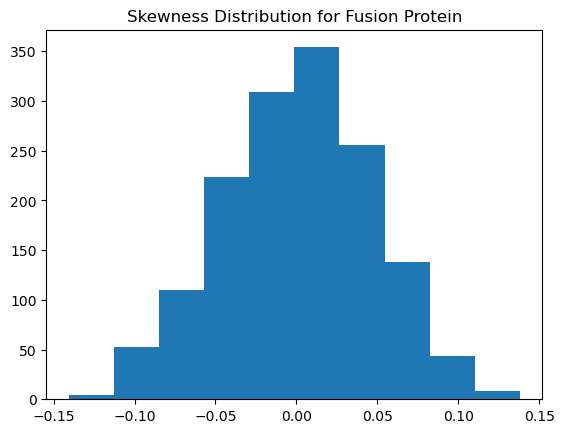

Identifying kurtosis for Fusion Protein dataset...


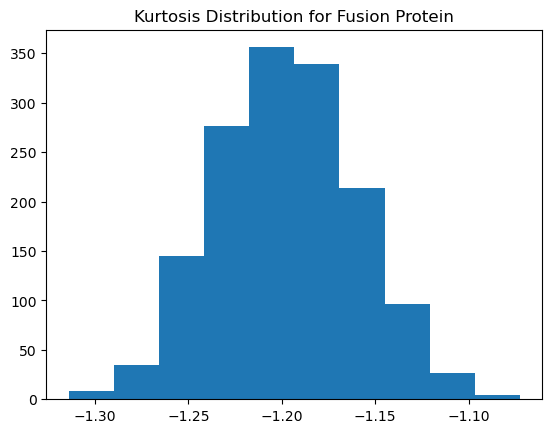

Transforming columns to reduce skewness and kurtosis for Fusion Protein dataset...
Preprocessing for Fusion Protein dataset complete.
Preprocessing Copy Number Alteration dataset...
Handling missing values for Copy Number Alteration dataset...
Encoding categorical variables for Copy Number Alteration dataset...
Identifying skewness for Copy Number Alteration dataset...


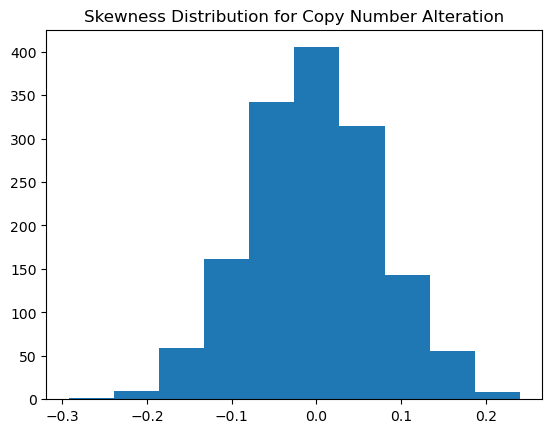

Identifying kurtosis for Copy Number Alteration dataset...


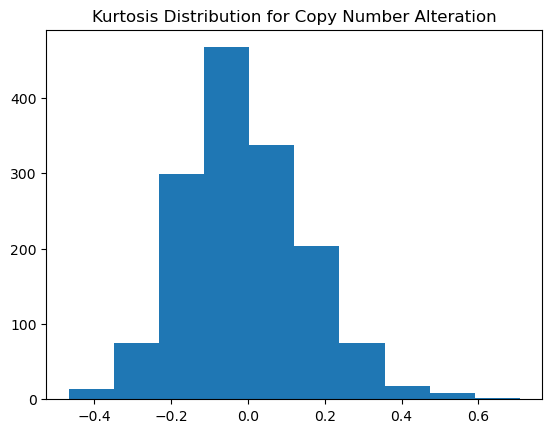

Transforming columns to reduce skewness and kurtosis for Copy Number Alteration dataset...
Preprocessing for Copy Number Alteration dataset complete.
Data preprocessing for all datasets complete.
Processed Transcriptomics Data:
   Transcript_0  Transcript_1  Transcript_2  Transcript_3  Transcript_4  \
0      0.716432      0.441097      0.435792      0.551870      0.734264   
1      0.550423      0.230121      0.822729      0.903504      0.786526   
2      0.783529      0.854236      0.653446      0.033074      0.234777   
3      0.636459      0.049299      0.138627      0.995206      0.498457   
4      0.277801      0.423640      0.882857      0.516765      0.407670   

   Transcript_5  Transcript_6  Transcript_7  Transcript_8  Transcript_9  ...  \
0      0.039182      0.945465      0.690890      0.193511      0.833809  ...   
1      0.189476      0.796224      0.578516      0.330149      0.823633  ...   
2      0.194550      0.365785      0.507546      0.158604      0.197653  ...   
3

In [15]:
import pandas as pd
import numpy as np

def generate_synthetic_data(num_samples=1000, num_features=1500):
    """
    Generate synthetic omics datasets with specified number of samples and features.
    
    Parameters:
    num_samples (int): Number of samples (rows) in each dataset.
    num_features (int): Number of features (columns) in each dataset.
    
    Returns:
    tuple: Six synthetic DataFrames representing different omics datasets.
    """
    
    # Generate random data for each dataset
    transcriptomics_data = np.random.rand(num_samples, num_features)
    proteomics_data = np.random.rand(num_samples, num_features)
    fusion_protein_data = np.random.rand(num_samples, num_features)
    cn_alteration_data = np.random.randn(num_samples, num_features)  # Normally distributed data

    # Create DataFrames
    transcriptomics_df = pd.DataFrame(transcriptomics_data, columns=[f'Transcript_{i}' for i in range(num_features)])
    proteomics_df = pd.DataFrame(proteomics_data, columns=[f'Protein_{i}' for i in range(num_features)])
    fusion_protein_df = pd.DataFrame(fusion_protein_data, columns=[f'Fusion_{i}' for i in range(num_features)])
    cn_alteration_df = pd.DataFrame(cn_alteration_data, columns=[f'CN_Alteration_{i}' for i in range(num_features)])
    

    return (transcriptomics_df, proteomics_df, fusion_protein_df, cn_alteration_df)

# Example usage
if __name__ == "__main__":
    # Generate synthetic datasets
    synthetic_datasets = generate_synthetic_data()
    
    # Unpack the datasets
    (transcriptomics_df, proteomics_df, fusion_protein_df, cn_alteration_df) = synthetic_datasets
    
    # Now you can use these datasets with your preprocessing function
    (processed_transcriptomics, processed_proteomics, processed_fusion_protein,processed_cn_alteration) = preprocess_multi_omics_datasets(
        transcriptomics_df,
        proteomics_df,
        fusion_protein_df,       
        cn_alteration_df,
    )
    
    # Example of accessing processed data
    print("Processed Transcriptomics Data:")
    print(processed_transcriptomics.head())


In [17]:
processed_proteomics

,Protein_0,Protein_1,Protein_2,Protein_3,Protein_4,Protein_5,Protein_6,Protein_7,Protein_8,Protein_9,...,Protein_1490,Protein_1491,Protein_1492,Protein_1493,Protein_1494,Protein_1495,Protein_1496,Protein_1497,Protein_1498,Protein_1499
0,0.950864,0.219733,0.989605,0.193172,0.725241,0.363706,0.484996,0.359931,0.558442,0.473107,...,0.776874,0.842734,0.171202,0.568310,0.284239,0.224714,0.949830,0.614991,0.597922,0.993942
1,0.048832,0.564917,0.492017,0.907162,0.504133,0.413216,0.561936,0.996676,0.893588,0.318628,...,0.802821,0.588443,0.353034,0.467383,0.627265,0.952743,0.554752,0.820762,0.433090,0.978825
2,0.211473,0.801706,0.555723,0.528698,0.398624,0.171258,0.390276,0.585173,0.720256,0.906205,...,0.957711,0.883337,0.727289,0.274105,0.904215,0.537786,0.670859,0.491468,0.987104,0.567600
3,0.322894,0.281673,0.081204,0.645660,0.489301,0.997400,0.169574,0.393510,0.388681,0.736577,...,0.588757,0.857391,0.853537,0.214770,0.688638,0.872488,0.625235,0.317984,0.677002,0.705435
4,0.480630,0.868620,0.044789,0.008073,0.315468,0.914546,0.435693,0.959926,0.926102,0.019228,...,0.867066,0.834278,0.606499,0.543513,0.844919,0.778536,0.421633,0.478406,0.756804,0.781804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.103203,0.708623,0.357921,0.508433,0.792624,0.630840,0.492056,0.519726,0.000689,0.785911,...,0.939312,0.918545,0.959178,0.804809,0.105569,0.628518,0.895717,0.420670,0.942536,0.632609
996,0.313970,0.137283,0.240225,0.309143,0.142151,0.908013,0.212909,0.016772,0.555711,0.950130,...,0.810819,0.154153,0.558573,0.877030,0.825315,0.776258,0.642639,0.764488,0.393764,0.308457
997,0.106700,0.366586,0.622408,0.611470,0.420660,0.789738,0.738293,0.462855,0.041972,0.589700,...,0.288188,0.441539,0.621594,0.541420,0.483865,0.608638,0.490945,0.594830,0.880184,0.537036
998,0.789769,0.484299,0.876254,0.116437,0.902878,0.067277,0.833697,0.740072,0.275039,0.736253,...,0.502462,0.371049,0.442626,0.797705,0.771302,0.908158,0.435164,0.807730,0.484352,0.861058


In [19]:
processed_fusion_protein

,Fusion_0,Fusion_1,Fusion_2,Fusion_3,Fusion_4,Fusion_5,Fusion_6,Fusion_7,Fusion_8,Fusion_9,...,Fusion_1490,Fusion_1491,Fusion_1492,Fusion_1493,Fusion_1494,Fusion_1495,Fusion_1496,Fusion_1497,Fusion_1498,Fusion_1499
0,0.742013,0.990807,0.547898,0.622162,0.734786,0.997513,0.089550,0.419683,0.404086,0.962640,...,0.815204,0.763096,0.895919,0.816085,0.753982,0.097012,0.725640,0.746338,0.887756,0.753821
1,0.882779,0.844471,0.461118,0.423950,0.861812,0.147739,0.227857,0.131906,0.230418,0.074634,...,0.994045,0.965786,0.612028,0.649361,0.359753,0.709616,0.636979,0.566111,0.629582,0.374515
2,0.025777,0.142619,0.227329,0.644544,0.709796,0.590620,0.432574,0.312328,0.480359,0.217332,...,0.543484,0.975588,0.380708,0.575996,0.937845,0.814431,0.605392,0.817369,0.789226,0.246971
3,0.958967,0.173638,0.600892,0.923771,0.260333,0.913703,0.191710,0.154006,0.451596,0.571382,...,0.492194,0.430886,0.953587,0.235433,0.792513,0.157009,0.456271,0.225666,0.757130,0.160840
4,0.847395,0.440809,0.224976,0.132919,0.519523,0.846922,0.098078,0.046597,0.831842,0.229384,...,0.904294,0.724979,0.765971,0.454118,0.804412,0.715914,0.549982,0.613748,0.353038,0.838779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.428558,0.592816,0.662174,0.942458,0.302088,0.787640,0.418560,0.620825,0.589586,0.022104,...,0.461217,0.927053,0.704011,0.849651,0.984493,0.117835,0.733731,0.830687,0.459079,0.815717
996,0.816696,0.325760,0.538312,0.045593,0.812046,0.218700,0.287644,0.597815,0.562078,0.167892,...,0.340401,0.942535,0.279848,0.984344,0.923480,0.904773,0.093827,0.472250,0.652333,0.629345
997,0.376400,0.174304,0.422346,0.759427,0.924138,0.031667,0.475168,0.619057,0.929179,0.428977,...,0.167268,0.777857,0.301168,0.816600,0.418859,0.986499,0.704618,0.009411,0.560398,0.530469
998,0.300421,0.179518,0.629456,0.001882,0.025386,0.195006,0.015530,0.992653,0.273327,0.571074,...,0.566702,0.547003,0.825850,0.969313,0.426340,0.809793,0.800756,0.923993,0.982859,0.762699


In [21]:
processed_cn_alteration

,CN_Alteration_0,CN_Alteration_1,CN_Alteration_2,CN_Alteration_3,CN_Alteration_4,CN_Alteration_5,CN_Alteration_6,CN_Alteration_7,CN_Alteration_8,CN_Alteration_9,...,CN_Alteration_1490,CN_Alteration_1491,CN_Alteration_1492,CN_Alteration_1493,CN_Alteration_1494,CN_Alteration_1495,CN_Alteration_1496,CN_Alteration_1497,CN_Alteration_1498,CN_Alteration_1499
0,-1.288768,0.107519,-1.432905,0.415102,1.780934,0.185986,0.787455,-1.002065,0.707903,1.399487,...,1.361697,0.941482,1.719937,1.486994,1.746281,1.378463,1.428849,1.658428,1.358621,1.212166
1,-1.100760,-0.558741,-0.173168,-0.563709,0.696270,1.197717,1.858192,-1.180132,0.757576,-0.175793,...,1.393146,1.273490,1.409319,1.346998,1.658638,1.248169,1.411466,1.570860,1.654778,1.342552
2,0.164504,-0.457165,0.710527,-0.923050,-1.088395,-0.225774,0.871915,-0.151805,-0.249230,-2.436577,...,1.443091,1.329848,1.417223,1.579297,1.441634,1.159761,1.650703,1.418020,1.520703,1.212681
3,0.564568,1.371483,-2.042239,-0.493280,-0.148303,0.826089,0.824650,-2.405148,-0.101222,-0.519369,...,1.003584,1.761973,1.741603,1.129967,1.674746,1.530207,1.543188,1.947293,1.555236,0.882676
4,-0.195359,-0.516883,-0.819339,1.204441,-0.121805,0.428206,0.309899,-1.435998,-0.431113,0.352169,...,1.181994,0.345180,1.325943,1.854053,1.556115,0.989768,1.488602,1.443397,1.532588,1.580658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.683490,-1.155071,0.311204,0.858639,-0.366364,0.907795,0.006093,0.739275,-0.557170,-0.805636,...,1.588053,1.301477,1.418447,0.960618,1.688191,1.443018,1.133995,1.456106,1.494870,1.398813
996,0.317955,-0.020815,0.328875,0.815764,0.360177,-0.499904,1.018786,0.425594,0.158201,0.030419,...,1.186930,1.516892,1.604945,1.801196,1.648733,1.087037,1.228498,1.460716,1.619446,1.840587
997,-0.763678,1.594688,0.232953,-0.213248,0.468020,-1.194492,0.975081,-2.049897,-0.846250,0.769877,...,1.233683,0.947113,1.694647,1.769817,1.594097,1.468077,1.536616,1.718962,1.808303,1.624583
998,-0.025887,-0.019623,-0.085855,-0.643355,1.150551,-0.233778,2.747520,0.299257,-0.352173,0.548185,...,1.494138,1.192192,1.625656,1.350414,1.805938,1.325318,1.597220,1.407655,1.518958,1.436519


below is a denoising autoencoder which is used to reduce the dimensionality of the dataset, include noise in guassian distribution, and prevent the overfitting. it concatenates the omics datasets processed and generates the multimodal dataset for further training purposes

In [23]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GaussianNoise, BatchNormalization, Dropout
import pandas as pd
import numpy as np

def build_denoising_autoencoder(input_shape):
    """
    Build and train a denoising autoencoder model for dimensionality reduction.
    
    Parameters:
    input_shape (tuple): Shape of the input data.
    
    Returns:
    tuple: Trained autoencoder model, encoder model, and encoded data DataFrame.
    """
    # Define the input layer
    input_data = keras.Input(shape=input_shape)
    
    # Add Gaussian noise to the input data
    noisy_input = GaussianNoise(0.25)(input_data)  # Adjust the standard deviation for more substantial noise
    
    # Encoder layers
    encoded = layers.Dense(500, activation='relu')(noisy_input)  # Change to 500 latent space
    encoded = Dropout(0.2)(encoded)  # Adding Dropout for regularization
    
    # Decoder layers
    decoded = layers.Dense(input_shape[0], activation='relu')(encoded)
    
    # Autoencoder model
    autoencoder = keras.Model(input_data, decoded)
    
    # Compile the autoencoder
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return autoencoder

def process_and_encode_datasets(datasets):
    """
    Process multiple datasets with denoising autoencoders and concatenate results.
    
    Parameters:
    datasets (list): List of DataFrames representing different omics datasets.
    
    Returns:
    DataFrame: Concatenated DataFrame of encoded representations.
    """
    encoded_dataframes = []
    
    for df in datasets:
        # Prepare data for training
        X_resampled = df.values  # Convert DataFrame to NumPy array
        
        # Build the denoising autoencoder
        autoencoder = build_denoising_autoencoder(input_shape=(X_resampled.shape[1],))
        
        # Train the autoencoder
        autoencoder.fit(X_resampled, X_resampled,
                        epochs=50,
                        batch_size=25,
                        shuffle=True,
                        validation_split=0.3,
                        verbose = 1,
                        callbacks=[EarlyStopping('val_loss', patience=10)])
        
        # Define the encoder model (up to the bottleneck layer)
        encoder = keras.Model(autoencoder.input, autoencoder.layers[1].output)  # Get output from first dense layer
        
        # Get the encoded data
        encoded_data = encoder.predict(X_resampled)
        encoded_df = pd.DataFrame(encoded_data)  # Convert to DataFrame
        
        encoded_dataframes.append(encoded_df)

    # Concatenate all encoded DataFrames along columns
    concatenated_df = pd.concat(encoded_dataframes, axis=1)
    
    return concatenated_df

# Example usage with your processed DataFrames
if __name__ == "__main__":
    datasets_to_process = [
        processed_transcriptomics,
        processed_proteomics,
        processed_fusion_protein,
        processed_cn_alteration
    ]
    
    multi_modal_dataset = process_and_encode_datasets(datasets_to_process)
    
    print("Multi-modal Dataset:")
    print(multi_modal_dataset.head())


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2936 - val_loss: 0.1501
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1476 - val_loss: 0.1413
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1318 - val_loss: 0.0894
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1102 - val_loss: 0.0960
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1061 - val_loss: 0.0992
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1014 - val_loss: 0.0670
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0926 - val_loss: 0.0650
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0883 - val_loss: 0.0810
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0848 - val_loss: 0.0631
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0807 - val_loss: 0.1005
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0861 - val_loss: 0.0612
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

In [59]:
multi_modal_dataset.to_excel('multi_modal_data_github.xlsx')

In [37]:
mol_data = pd.read_excel(r'C:\Users\Admin\Downloads\PADEL_Inactiv_Mol_Descs_FingPrnt.xlsx')

In [41]:
mol_data = mol_data.set_index('SMILES_ID')

In [131]:
mol_data
""" This is a Molecular descriptors dataset imported for demonstration, a snippet of it is used to concatenate
with the processed omics datasets for further training purposes"""

' This is a Molecular descriptors dataset imported for demonstration, a snippet of it is used to concatenate with the processed omics datasets for further training purposes'

In [45]:
mol_data_X = mol_data.drop(['IC50 (micro molar)'], axis = 1)

In [47]:
mol_data_X

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,minsBr,minsSnH3,minssSnH2,minsssSnH,minssssSn,minsI,minsPbH3,minssPbH2,minsssPbH,minssssPb
SMILES_ID,,,,,,,,,,,,,,,,,,,,,
[O-][N+](=O)c(c1)ccc(c12)nc(s2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5ccc(O)cc5,0,-0.1641,0.026929,48.4891,62.295895,20,21,49,34,15,...,0.000000,0,0,0,0,0,0,0,0,0
Cc(o1)ccc1C(=O)C(=C(C2=O)O)[C@@H](c3ccc(C(C)(C)C)cc3)N2c(s4)nc(c45)ccc(c5)[N+]([O-])=O,0,1.8524,3.431386,65.0513,73.868239,20,21,60,37,23,...,0.000000,0,0,0,0,0,0,0,0,0
COc(c1)ccc(c12)nc(s2)N([C@@H]3c4ccc(cc4)C(C)(C)C)C(=O)C(O)=C3C(=O)c5ccc(o5)C,0,1.3398,1.795064,49.3951,60.750309,20,21,46,33,13,...,0.000000,0,0,0,0,0,0,0,0,0
Clc1ccc(cc1)-c2nc(sc2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5cccc(c5)[N+](=O)[O-],0,0.2530,0.064009,44.7184,68.822274,18,28,52,34,18,...,0.267331,0,0,0,0,0,0,0,0,0
Cc1ccc(cc1)-c2csc(n2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5cccc(c5)[N+](=O)[O-],0,-0.6876,0.472794,43.4351,70.334653,18,28,56,35,21,...,0.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1ccccc1[S+]([O-])c(c2)c(=O)oc(c23)c4c(cccc4)n(c3=O)Cc5ccccc5,0,-1.5084,2.275271,18.4454,62.543481,26,28,48,31,17,...,0.000000,0,0,0,0,0,0,0,0,0
CSc(c1)c(=O)oc(c12)c3c(cccc3)n(c2=O)Cc4ccccc4,0,-0.0214,0.000458,31.9356,51.607895,12,22,40,25,15,...,0.000000,0,0,0,0,0,0,0,0,0
C[S+]([O-])c(c1)c(=O)oc(c12)c3c(cccc3)n(c2=O)Cc4ccccc4,0,-1.4061,1.977117,24.1421,52.409895,20,22,41,26,15,...,0.000000,0,0,0,0,0,0,0,0,0


In [55]:
import pandas as pd
import numpy as np

# Assuming mol_data_X is your existing DataFrame
# For demonstration, let's create a sample mol_data_X (you can skip this part)
# mol_data_X = pd.DataFrame(np.random.rand(1800, 1200), columns=[f'descriptor_{i+1}' for i in range(1200)])

# Step 1: Extract the first 1000 column names from mol_data_X
column_names = mol_data_X.columns[:1000]

# Step 2: Generate random data for the synthetic DataFrame
num_rows = 1000
num_columns = len(column_names)  # Should be 1000 based on our selection

# Create a DataFrame with random values
synthetic_data = np.random.rand(num_rows, num_columns)
synthetic_df = pd.DataFrame(synthetic_data, columns=column_names)

# Display the resulting synthetic DataFrame
print("Synthetic DataFrame:")
print(synthetic_df.head())
synthetic_df.to_excel('mol_data_for_github.xlsx')

Synthetic DataFrame:
      nAcid     ALogP    ALogp2       AMR      apol  naAromAtom  nAromBond  \
0  0.820659  0.260418  0.301972  0.059913  0.635340    0.647482   0.199333   
1  0.392462  0.428027  0.459733  0.042084  0.060603    0.011142   0.999329   
2  0.337663  0.682657  0.576068  0.819405  0.307446    0.282573   0.117357   
3  0.526205  0.137509  0.101323  0.994978  0.552343    0.536147   0.987474   
4  0.167576  0.736855  0.742668  0.237135  0.405703    0.515589   0.117553   

      nAtom  nHeavyAtom        nH  ...  minssssssS     minSm    minsCl  \
0  0.765696    0.325878  0.945846  ...    0.339551  0.202322  0.593805   
1  0.918894    0.833410  0.155762  ...    0.246744  0.285242  0.481203   
2  0.105940    0.759558  0.525506  ...    0.950807  0.057319  0.104718   
3  0.382291    0.097227  0.448894  ...    0.140012  0.994120  0.278021   
4  0.689884    0.942002  0.521121  ...    0.189512  0.027493  0.779590   

   minsGeH3  minssGeH2  minsssGeH  minssssGe  minsAsH2  minssAsH 

In [56]:
synthetic_df

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,minssssssS,minSm,minsCl,minsGeH3,minssGeH2,minsssGeH,minssssGe,minsAsH2,minssAsH,minsssAs
0,0.820659,0.260418,0.301972,0.059913,0.635340,0.647482,0.199333,0.765696,0.325878,0.945846,...,0.339551,0.202322,0.593805,0.548547,0.268233,0.606793,0.234708,0.529103,0.963097,0.320896
1,0.392462,0.428027,0.459733,0.042084,0.060603,0.011142,0.999329,0.918894,0.833410,0.155762,...,0.246744,0.285242,0.481203,0.854424,0.331572,0.286649,0.096475,0.418513,0.205476,0.084049
2,0.337663,0.682657,0.576068,0.819405,0.307446,0.282573,0.117357,0.105940,0.759558,0.525506,...,0.950807,0.057319,0.104718,0.226368,0.525924,0.473926,0.146791,0.672756,0.846783,0.630074
3,0.526205,0.137509,0.101323,0.994978,0.552343,0.536147,0.987474,0.382291,0.097227,0.448894,...,0.140012,0.994120,0.278021,0.974416,0.241715,0.878983,0.652887,0.992593,0.100860,0.818129
4,0.167576,0.736855,0.742668,0.237135,0.405703,0.515589,0.117553,0.689884,0.942002,0.521121,...,0.189512,0.027493,0.779590,0.500192,0.255818,0.773748,0.047307,0.795235,0.878354,0.010202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.191689,0.513473,0.751067,0.709426,0.334887,0.324337,0.687819,0.643585,0.661062,0.165365,...,0.945565,0.482156,0.920336,0.356285,0.356614,0.573816,0.734816,0.352699,0.353207,0.522829
996,0.800265,0.352063,0.662652,0.013283,0.693599,0.507005,0.098936,0.321067,0.991988,0.982330,...,0.110850,0.454145,0.575997,0.983315,0.977232,0.791820,0.338450,0.714038,0.396253,0.241699
997,0.586050,0.971271,0.832455,0.646492,0.409518,0.870405,0.708683,0.779962,0.502658,0.524481,...,0.811470,0.468982,0.652635,0.778385,0.837883,0.228853,0.156935,0.204521,0.719470,0.472186
998,0.907479,0.752627,0.211133,0.679781,0.495639,0.272787,0.280616,0.021734,0.728236,0.087176,...,0.758558,0.228090,0.041350,0.770857,0.049600,0.241182,0.757692,0.581494,0.583336,0.973745


In [62]:
concat_data = pd.concat([synthetic_df, multi_modal_dataset], axis = 1)

In [64]:
concat_data

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.820659,0.260418,0.301972,0.059913,0.635340,0.647482,0.199333,0.765696,0.325878,0.945846,...,1.361697,0.941482,1.719937,1.486994,1.746281,1.378463,1.428849,1.658428,1.358621,1.212166
1,0.392462,0.428027,0.459733,0.042084,0.060603,0.011142,0.999329,0.918894,0.833410,0.155762,...,1.393146,1.273490,1.409319,1.346998,1.658638,1.248169,1.411466,1.570860,1.654778,1.342552
2,0.337663,0.682657,0.576068,0.819405,0.307446,0.282573,0.117357,0.105940,0.759558,0.525506,...,1.443091,1.329848,1.417223,1.579297,1.441634,1.159761,1.650703,1.418020,1.520703,1.212681
3,0.526205,0.137509,0.101323,0.994978,0.552343,0.536147,0.987474,0.382291,0.097227,0.448894,...,1.003584,1.761973,1.741603,1.129967,1.674746,1.530207,1.543188,1.947293,1.555236,0.882676
4,0.167576,0.736855,0.742668,0.237135,0.405703,0.515589,0.117553,0.689884,0.942002,0.521121,...,1.181994,0.345180,1.325943,1.854053,1.556115,0.989768,1.488602,1.443397,1.532588,1.580658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.191689,0.513473,0.751067,0.709426,0.334887,0.324337,0.687819,0.643585,0.661062,0.165365,...,1.588053,1.301477,1.418447,0.960618,1.688191,1.443018,1.133996,1.456106,1.494870,1.398813
996,0.800265,0.352063,0.662652,0.013283,0.693599,0.507005,0.098936,0.321067,0.991988,0.982330,...,1.186930,1.516892,1.604945,1.801196,1.648733,1.087037,1.228498,1.460716,1.619446,1.840587
997,0.586050,0.971271,0.832455,0.646492,0.409518,0.870405,0.708683,0.779962,0.502658,0.524481,...,1.233683,0.947113,1.694647,1.769817,1.594097,1.468077,1.536616,1.718962,1.808303,1.624583
998,0.907479,0.752627,0.211133,0.679781,0.495639,0.272787,0.280616,0.021734,0.728236,0.087176,...,1.494138,1.192192,1.625656,1.350414,1.805938,1.325318,1.597219,1.407655,1.518958,1.436519


In [66]:
from sklearn.model_selection import train_test_split

In [96]:
import pandas as pd
import numpy as np

def fill_nulls_with_mean(df):
    """
    Fill null values in the DataFrame with the mean of each column.

    Parameters:
    df (DataFrame): The input DataFrame with potential null values.

    Returns:
    DataFrame: A new DataFrame with null values filled with column means.
    """
    # Create a copy of the original DataFrame to avoid modifying it in place
    filled_df = df.copy()
    
    # Iterate over each column in the DataFrame
    for column in filled_df.columns:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(filled_df[column]):
            if filled_df[column].isnull().any():  # Check if there are any null values
                mean_value = filled_df[column].mean()  # Calculate the mean of the column
                filled_df[column].fillna(mean_value, inplace=True)  # Fill nulls with the mean
    
    return filled_df

In [97]:
  # Fill null values with mean
concat_data = fill_nulls_with_mean(concat_data)
    
print("\nDataFrame after filling nulls with mean:")
print(concat_data)



DataFrame after filling nulls with mean:
        nAcid     ALogP    ALogp2       AMR      apol  naAromAtom  nAromBond  \
0    0.820659  0.260418  0.301972  0.059913  0.635340    0.647482   0.199333   
1    0.392462  0.428027  0.459733  0.042084  0.060603    0.011142   0.999329   
2    0.337663  0.682657  0.576068  0.819405  0.307446    0.282573   0.117357   
3    0.526205  0.137509  0.101323  0.994978  0.552343    0.536147   0.987474   
4    0.167576  0.736855  0.742668  0.237135  0.405703    0.515589   0.117553   
..        ...       ...       ...       ...       ...         ...        ...   
995  0.191689  0.513473  0.751067  0.709426  0.334887    0.324337   0.687819   
996  0.800265  0.352063  0.662652  0.013283  0.693599    0.507005   0.098936   
997  0.586050  0.971271  0.832455  0.646492  0.409518    0.870405   0.708683   
998  0.907479  0.752627  0.211133  0.679781  0.495639    0.272787   0.280616   
999  0.961670  0.457403  0.368365  0.262888  0.992752    0.759359   0.616185  

In [110]:
X = concat_data.copy()

In [112]:
X

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.820659,0.260418,0.301972,0.059913,0.635340,0.647482,0.199333,0.765696,0.325878,0.945846,...,1.361697,0.941482,1.719937,1.486994,1.746281,1.378463,1.428849,1.658428,1.358621,1.212166
1,0.392462,0.428027,0.459733,0.042084,0.060603,0.011142,0.999329,0.918894,0.833410,0.155762,...,1.393146,1.273490,1.409319,1.346998,1.658638,1.248169,1.411466,1.570860,1.654778,1.342552
2,0.337663,0.682657,0.576068,0.819405,0.307446,0.282573,0.117357,0.105940,0.759558,0.525506,...,1.443091,1.329848,1.417223,1.579297,1.441634,1.159761,1.650703,1.418020,1.520703,1.212681
3,0.526205,0.137509,0.101323,0.994978,0.552343,0.536147,0.987474,0.382291,0.097227,0.448894,...,1.003584,1.761973,1.741603,1.129967,1.674746,1.530207,1.543188,1.947293,1.555236,0.882676
4,0.167576,0.736855,0.742668,0.237135,0.405703,0.515589,0.117553,0.689884,0.942002,0.521121,...,1.181994,0.345180,1.325943,1.854053,1.556115,0.989768,1.488602,1.443397,1.532588,1.580658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.191689,0.513473,0.751067,0.709426,0.334887,0.324337,0.687819,0.643585,0.661062,0.165365,...,1.588053,1.301477,1.418447,0.960618,1.688191,1.443018,1.133996,1.456106,1.494870,1.398813
996,0.800265,0.352063,0.662652,0.013283,0.693599,0.507005,0.098936,0.321067,0.991988,0.982330,...,1.186930,1.516892,1.604945,1.801196,1.648733,1.087037,1.228498,1.460716,1.619446,1.840587
997,0.586050,0.971271,0.832455,0.646492,0.409518,0.870405,0.708683,0.779962,0.502658,0.524481,...,1.233683,0.947113,1.694647,1.769817,1.594097,1.468077,1.536616,1.718962,1.808303,1.624583
998,0.907479,0.752627,0.211133,0.679781,0.495639,0.272787,0.280616,0.021734,0.728236,0.087176,...,1.494138,1.192192,1.625656,1.350414,1.805938,1.325318,1.597219,1.407655,1.518958,1.436519


In [68]:
y = pd.DataFrame(mol_data['IC50 (micro molar)'])

In [100]:
  # Fill null values with mean
y = fill_nulls_with_mean(y)
    
print("\nDataFrame after filling nulls with mean:")
print(y)



DataFrame after filling nulls with mean:
                                                    IC50 (micro molar)
SMILES_ID                                                             
[O-][N+](=O)c(c1)ccc(c12)nc(s2)N3C(=O)C(O)=C(C(...            0.513648
Cc(o1)ccc1C(=O)C(=C(C2=O)O)[C@@H](c3ccc(C(C)(C)...            0.335146
COc(c1)ccc(c12)nc(s2)N([C@@H]3c4ccc(cc4)C(C)(C)...            0.334689
Clc1ccc(cc1)-c2nc(sc2)N3C(=O)C(O)=C(C(=O)c4ccc(...            0.165820
Cc1ccc(cc1)-c2csc(n2)N3C(=O)C(O)=C(C(=O)c4ccc(o...            0.177173
...                                                                ...
c1cc(F)cc(c12)sc(n2)N3C(=O)C(OCc4ccccn4)=C(C(=O...            0.000000
c1ccccc1[C@@H]2C(C(=O)c3ccc(o3)C)=C(OCc4ccco4)C...            0.000000
Fc1ccccc1[C@H]2C(C(=O)CCC(=O)OCC)=C(O)C(=O)N2c(...            0.337670
CCOC(=O)CCC(=O)C([C@H]1c2ccc(F)cc2)=C(O)C(=O)N1...            0.333639
CCOC(=O)CCC(=O)C(=C(C1=O)O)C(c2ccc(Cl)cc2)N1c(n...            0.314816

[1000 rows x 1 columns]


In [102]:
y

,IC50 (micro molar)
SMILES_ID,
[O-][N+](=O)c(c1)ccc(c12)nc(s2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5ccc(O)cc5,0.513648
Cc(o1)ccc1C(=O)C(=C(C2=O)O)[C@@H](c3ccc(C(C)(C)C)cc3)N2c(s4)nc(c45)ccc(c5)[N+]([O-])=O,0.335146
COc(c1)ccc(c12)nc(s2)N([C@@H]3c4ccc(cc4)C(C)(C)C)C(=O)C(O)=C3C(=O)c5ccc(o5)C,0.334689
Clc1ccc(cc1)-c2nc(sc2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5cccc(c5)[N+](=O)[O-],0.165820
Cc1ccc(cc1)-c2csc(n2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5cccc(c5)[N+](=O)[O-],0.177173
...,...
c1cc(F)cc(c12)sc(n2)N3C(=O)C(OCc4ccccn4)=C(C(=O)c5ccc(o5)C)C3c6ccccc6,0.000000
c1ccccc1[C@@H]2C(C(=O)c3ccc(o3)C)=C(OCc4ccco4)C(=O)N2c(n5)sc(c56)cc(F)cc6,0.000000
Fc1ccccc1[C@H]2C(C(=O)CCC(=O)OCC)=C(O)C(=O)N2c(s3)nc(c34)ccc(F)c4,0.337670


In [104]:
y = y.iloc[:1000]

In [106]:
y

,IC50 (micro molar)
SMILES_ID,
[O-][N+](=O)c(c1)ccc(c12)nc(s2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5ccc(O)cc5,0.513648
Cc(o1)ccc1C(=O)C(=C(C2=O)O)[C@@H](c3ccc(C(C)(C)C)cc3)N2c(s4)nc(c45)ccc(c5)[N+]([O-])=O,0.335146
COc(c1)ccc(c12)nc(s2)N([C@@H]3c4ccc(cc4)C(C)(C)C)C(=O)C(O)=C3C(=O)c5ccc(o5)C,0.334689
Clc1ccc(cc1)-c2nc(sc2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5cccc(c5)[N+](=O)[O-],0.165820
Cc1ccc(cc1)-c2csc(n2)N3C(=O)C(O)=C(C(=O)c4ccc(o4)C)[C@H]3c5cccc(c5)[N+](=O)[O-],0.177173
...,...
c1cc(F)cc(c12)sc(n2)N3C(=O)C(OCc4ccccn4)=C(C(=O)c5ccc(o5)C)C3c6ccccc6,0.000000
c1ccccc1[C@@H]2C(C(=O)c3ccc(o3)C)=C(OCc4ccco4)C(=O)N2c(n5)sc(c56)cc(F)cc6,0.000000
Fc1ccccc1[C@H]2C(C(=O)CCC(=O)OCC)=C(O)C(=O)N2c(s3)nc(c34)ccc(F)c4,0.337670


In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Display the shapes of the resulting datasets
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training target set shape:", Y_train.shape)
print("Testing target set shape:", Y_test.shape)

Training feature set shape: (800, 7000)
Testing feature set shape: (200, 7000)
Training target set shape: (800, 1)
Testing target set shape: (200, 1)


Below program demonstrates a Deep neural network with hypeopt based optimization function to finetune the hyperparameters - returns the best parameters and trains on the obtained parameters

In [124]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt

# Assuming X_train, X_test, Y_train, Y_test are already defined.
# Replace with your actual data-loading code if needed.

# Define a function to create a DNN model
def create_model(input_dim, params):
    model = Sequential()
    model.add(Dense(params['units_layer1'], input_dim=input_dim, activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['units_layer2'], activation=params['activation']))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')
    return model

# Define the objective function for hyperparameter optimization
def objective_function(params):
    input_dim = X_train.shape[1]
    model = create_model(input_dim, params)

    # Train the model
    model.fit(X_train, Y_train, epochs=20, batch_size=params['batch_size'], verbose=0)

    # Evaluate on the test set
    predictions = model.predict(X_test, verbose=2)
    mse = mean_squared_error(Y_test, predictions)

    # Log the loss for tracking
    print(f"MSE: {mse}, Params: {params}")
    return {'loss': mse, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'units_layer1': hp.choice('units_layer1', [64, 128, 256]),
    'units_layer2': hp.choice('units_layer2', [32, 64, 128]),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

# Run the optimization
trials = Trials()
best_params = fmin(
    fn=objective_function,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

# Extract and display the results
print("Best Hyperparameters:", best_params)

# Analyze how the loss changed with each combination
results = pd.DataFrame({
    'MSE': [x['result']['loss'] for x in trials.trials],
    'Params': [x['misc']['vals'] for x in trials.trials]
})

print("\nOptimization Results:")
print(results)

# Train the best model with the optimal hyperparameters
input_dim = X_train.shape[1]
optimal_params = {
    'units_layer1': [64, 128, 256][best_params['units_layer1']],
    'units_layer2': [32, 64, 128][best_params['units_layer2']],
    'activation': ['relu', 'tanh'][best_params['activation']],
    'dropout': best_params['dropout'],
    'learning_rate': best_params['learning_rate'],
    'batch_size': [16, 32, 64][best_params['batch_size']]
}

final_model = create_model(input_dim, optimal_params)
final_model.fit(X_train, Y_train, epochs=50, batch_size=optimal_params['batch_size'], verbose=2)

# Predictions and performance metrics
predictions = final_model.predict(X_test)
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f"Final Model Metrics:\nMSE: {mse}\nRMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 32ms/step                                                                                                   

MSE: 0.01204436104821629, Params: {'activation': 'tanh', 'batch_size': 32, 'dropout': 0.25638265375039154, 'learning_rate': 0.007140929171113858, 'units_layer1': 256, 'units_layer2': 64}
  2%|▉                                               | 1/50 [00:21<17:25, 21.35s/trial, best loss: 0.01204436104821629]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 28ms/step                                                                                                   

MSE: 0.03414285828433803, Params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.30557727142853475, 'learning_rate': 0.008732419935791793, 'units_layer1': 64, 'units_layer2': 128}
  4%|█▉                                              | 2/50 [00:30<11:18, 14.13s/trial, best loss: 0.01204436104821629]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 24ms/step                                                                                                   

MSE: 0.012890006703734944, Params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1833589560427028, 'learning_rate': 0.00020037393409076928, 'units_layer1': 256, 'units_layer2': 64}
  6%|██▉                                             | 3/50 [00:48<12:20, 15.76s/trial, best loss: 0.01204436104821629]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 23ms/step                                                                                                   

MSE: 0.013215875201613153, Params: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.1531035864238636, 'learning_rate': 0.004162914172323235, 'units_layer1': 128, 'units_layer2': 128}
  8%|███▊                                            | 4/50 [00:55<09:38, 12.57s/trial, best loss: 0.01204436104821629]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 22ms/step                                                                                                   

MSE: 0.011660384713750771, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.45086130958496307, 'learning_rate': 0.0001348330798864866, 'units_layer1': 128, 'units_layer2': 32}
 10%|████▋                                          | 5/50 [01:03<07:58, 10.64s/trial, best loss: 0.011660384713750771]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 23ms/step                                                                                                   

MSE: 0.012349640558390378, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.15965740938350828, 'learning_rate': 0.0008200656172873102, 'units_layer1': 256, 'units_layer2': 128}
 12%|█████▋                                         | 6/50 [01:13<07:50, 10.70s/trial, best loss: 0.011660384713750771]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 24ms/step                                                                                                   

MSE: 0.011224683150190557, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.19172207831544702, 'learning_rate': 0.001358310459120998, 'units_layer1': 256, 'units_layer2': 128}
 14%|██████▌                                        | 7/50 [01:43<12:05, 16.87s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 26ms/step                                                                                                   

MSE: 0.017934319659981424, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.25138286826157363, 'learning_rate': 0.0026194014908282703, 'units_layer1': 64, 'units_layer2': 64}
 16%|███████▌                                       | 8/50 [01:53<10:24, 14.87s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 22ms/step                                                                                                   

MSE: 0.011367264103615844, Params: {'activation': 'tanh', 'batch_size': 32, 'dropout': 0.19655154920342197, 'learning_rate': 0.000285010839158881, 'units_layer1': 64, 'units_layer2': 64}
 18%|████████▍                                      | 9/50 [02:00<08:26, 12.36s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 23ms/step                                                                                                   

MSE: 0.01399466408959396, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.20283523793999791, 'learning_rate': 0.00030215573931187986, 'units_layer1': 64, 'units_layer2': 32}
 20%|█████████▏                                    | 10/50 [02:06<06:45, 10.14s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 23ms/step                                                                                                   

MSE: 0.01803861862432842, Params: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.277039972007573, 'learning_rate': 0.00013918886790517345, 'units_layer1': 64, 'units_layer2': 32}
 22%|██████████                                    | 11/50 [02:11<05:37,  8.65s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 1s - 110ms/step                                                                                                  

MSE: 0.011873715910923566, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.42249785977745946, 'learning_rate': 0.00019769047186796906, 'units_layer1': 128, 'units_layer2': 128}
 24%|███████████                                   | 12/50 [02:21<05:41,  8.99s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 1s - 118ms/step                                                                                                  

MSE: 0.02539118740532917, Params: {'activation': 'relu', 'batch_size': 16, 'dropout': 0.3908883579123217, 'learning_rate': 0.0035711646042250727, 'units_layer1': 128, 'units_layer2': 128}
 26%|███████████▉                                  | 13/50 [02:44<08:15, 13.39s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 26ms/step                                                                                                   

MSE: 0.011254056861233703, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.4326018334439715, 'learning_rate': 0.0038542814482214484, 'units_layer1': 128, 'units_layer2': 32}
 28%|████████████▉                                 | 14/50 [03:02<08:50, 14.74s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 33ms/step                                                                                                   

MSE: 0.015693946694021393, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.1683019318360091, 'learning_rate': 0.005151743816572911, 'units_layer1': 128, 'units_layer2': 128}
 30%|█████████████▊                                | 15/50 [03:24<09:50, 16.87s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 25ms/step                                                                                                   

MSE: 0.9133944635646108, Params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2972945122180166, 'learning_rate': 0.008992504365675807, 'units_layer1': 128, 'units_layer2': 64}
 32%|██████████████▋                               | 16/50 [03:39<09:22, 16.54s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 33ms/step                                                                                                   

MSE: 0.014022390752318868, Params: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.2583453890935774, 'learning_rate': 0.0037372354424535493, 'units_layer1': 128, 'units_layer2': 32}
 34%|███████████████▋                              | 17/50 [03:50<08:05, 14.70s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 26ms/step                                                                                                   

MSE: 0.013380373218869148, Params: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.20322466530280156, 'learning_rate': 0.0020866473470027387, 'units_layer1': 64, 'units_layer2': 128}
 36%|████████████████▌                             | 18/50 [03:57<06:32, 12.27s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 24ms/step                                                                                                   

MSE: 0.011301931068816993, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.406780570697132, 'learning_rate': 0.0009952741545833903, 'units_layer1': 64, 'units_layer2': 128}
 38%|█████████████████▍                            | 19/50 [04:07<05:59, 11.60s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 34ms/step                                                                                                   

MSE: 0.016199661535946208, Params: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.44794659511170276, 'learning_rate': 0.00020371610536780237, 'units_layer1': 128, 'units_layer2': 32}
 40%|██████████████████▍                           | 20/50 [05:06<12:57, 25.92s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 52ms/step                                                                                                   

MSE: 0.011227170913112285, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.11139386225125852, 'learning_rate': 0.0016160024334333479, 'units_layer1': 256, 'units_layer2': 32}
 42%|███████████████████▎                          | 21/50 [05:42<14:04, 29.11s/trial, best loss: 0.011224683150190557]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 31ms/step                                                                                                   

MSE: 0.011222778180639317, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.10405601851347956, 'learning_rate': 0.0006221240595459959, 'units_layer1': 256, 'units_layer2': 32}
 44%|████████████████████▏                         | 22/50 [06:26<15:33, 33.34s/trial, best loss: 0.011222778180639317]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 26ms/step                                                                                                   

MSE: 0.01124847162025222, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.10329107559526404, 'learning_rate': 0.0006055288650575016, 'units_layer1': 256, 'units_layer2': 32}
 46%|█████████████████████▏                        | 23/50 [06:57<14:41, 32.64s/trial, best loss: 0.011222778180639317]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 1s - 85ms/step                                                                                                   

MSE: 0.011607620569118722, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.1266245075924164, 'learning_rate': 0.000548280568381539, 'units_layer1': 256, 'units_layer2': 32}
 48%|██████████████████████                        | 24/50 [07:32<14:31, 33.52s/trial, best loss: 0.011222778180639317]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 35ms/step                                                                                                   

MSE: 0.011268173430020768, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.2289023466801668, 'learning_rate': 0.0014828221171076766, 'units_layer1': 256, 'units_layer2': 128}
 50%|███████████████████████                       | 25/50 [08:10<14:33, 34.94s/trial, best loss: 0.011222778180639317]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 1s - 100ms/step                                                                                                  

MSE: 0.019592379261970758, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.32453819354354096, 'learning_rate': 0.0005060226144078044, 'units_layer1': 256, 'units_layer2': 128}
 52%|███████████████████████▉                      | 26/50 [08:46<14:01, 35.08s/trial, best loss: 0.011222778180639317]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 40ms/step                                                                                                   

MSE: 0.012765101492423915, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.35128552441544236, 'learning_rate': 0.0003847203544328747, 'units_layer1': 256, 'units_layer2': 32}
 54%|████████████████████████▊                     | 27/50 [09:32<14:45, 38.51s/trial, best loss: 0.011222778180639317]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 32ms/step                                                                                                   

MSE: 0.011219525636900683, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.13358383867527412, 'learning_rate': 0.0011530630297872841, 'units_layer1': 256, 'units_layer2': 32}
 56%|█████████████████████████▊                    | 28/50 [10:06<13:37, 37.15s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 28ms/step                                                                                                   

MSE: 0.01171626262898817, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.4974306860291042, 'learning_rate': 0.0007445718774490184, 'units_layer1': 256, 'units_layer2': 32}
 58%|██████████████████████████▋                   | 29/50 [10:43<12:56, 36.99s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 30ms/step                                                                                                   

MSE: 0.011534504479452576, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.13255017710135963, 'learning_rate': 0.001133602707121642, 'units_layer1': 256, 'units_layer2': 32}
 60%|███████████████████████████▌                  | 30/50 [11:16<11:58, 35.93s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 29ms/step                                                                                                   

MSE: 0.011363401206538963, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.13890733202291122, 'learning_rate': 0.002079192752068918, 'units_layer1': 256, 'units_layer2': 32}
 62%|████████████████████████████▌                 | 31/50 [11:53<11:24, 36.02s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 63ms/step                                                                                                   

MSE: 0.01421929335762024, Params: {'activation': 'tanh', 'batch_size': 32, 'dropout': 0.2259445777520238, 'learning_rate': 0.0004146058230182435, 'units_layer1': 256, 'units_layer2': 32}
 64%|█████████████████████████████▍                | 32/50 [12:13<09:25, 31.42s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 59ms/step                                                                                                   

MSE: 0.011466209223284096, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.10282383941487586, 'learning_rate': 0.0007732567303606455, 'units_layer1': 256, 'units_layer2': 64}
 66%|██████████████████████████████▎               | 33/50 [13:09<10:56, 38.64s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 46ms/step                                                                                                   

MSE: 0.011235294061609278, Params: {'activation': 'tanh', 'batch_size': 32, 'dropout': 0.17093685839200062, 'learning_rate': 0.0011006435000055568, 'units_layer1': 256, 'units_layer2': 32}
 68%|███████████████████████████████▎              | 34/50 [13:36<09:21, 35.12s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 57ms/step                                                                                                   

MSE: 0.011544427257844441, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.3454901236277521, 'learning_rate': 0.00242952160769184, 'units_layer1': 256, 'units_layer2': 32}
 70%|████████████████████████████████▏             | 35/50 [14:17<09:14, 36.96s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 32ms/step                                                                                                   

MSE: 0.015817792717722497, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.14254892850480452, 'learning_rate': 0.006527675387737496, 'units_layer1': 256, 'units_layer2': 64}
 72%|█████████████████████████████████             | 36/50 [14:50<08:20, 35.74s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 29ms/step                                                                                                   

MSE: 0.011633198930192504, Params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.10019114269568967, 'learning_rate': 0.00030043249126569853, 'units_layer1': 256, 'units_layer2': 32}
 74%|██████████████████████████████████            | 37/50 [15:09<06:39, 30.70s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 34ms/step                                                                                                   

MSE: 0.011267356541023692, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.49020772742976426, 'learning_rate': 0.00011798282489578289, 'units_layer1': 256, 'units_layer2': 32}
 76%|██████████████████████████████████▉           | 38/50 [15:40<06:11, 30.97s/trial, best loss: 0.011219525636900683]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 29ms/step                                                                                                   

MSE: 0.011215890686758143, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.23116108196703916, 'learning_rate': 0.0008784438224297397, 'units_layer1': 256, 'units_layer2': 64}
 78%|███████████████████████████████████▉          | 39/50 [16:15<05:53, 32.12s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 32ms/step                                                                                                   

MSE: 0.013155934268547727, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.23005918468741637, 'learning_rate': 0.0009158432729020797, 'units_layer1': 64, 'units_layer2': 64}
 80%|████████████████████████████████████▊         | 40/50 [16:28<04:21, 26.20s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 27ms/step                                                                                                   

MSE: 0.017490892426763213, Params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.28039912438587966, 'learning_rate': 0.0017370286614768057, 'units_layer1': 256, 'units_layer2': 64}
 82%|█████████████████████████████████████▋        | 41/50 [16:47<03:37, 24.11s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 25ms/step                                                                                                   

MSE: 0.011928622858895614, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.24735140794047145, 'learning_rate': 0.0029161558331160715, 'units_layer1': 256, 'units_layer2': 64}
 84%|██████████████████████████████████████▋       | 42/50 [17:18<03:30, 26.35s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 25ms/step                                                                                                   

MSE: 0.013064995277180538, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.18283204687560078, 'learning_rate': 0.0012605914229209952, 'units_layer1': 64, 'units_layer2': 64}
 86%|███████████████████████████████████████▌      | 43/50 [17:32<02:37, 22.50s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 27ms/step                                                                                                   

MSE: 0.011440575837216643, Params: {'activation': 'tanh', 'batch_size': 32, 'dropout': 0.3181190197090554, 'learning_rate': 0.0002380070230600649, 'units_layer1': 256, 'units_layer2': 64}
 88%|████████████████████████████████████████▍     | 44/50 [17:57<02:20, 23.36s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 28ms/step                                                                                                   

MSE: 0.02908550998539545, Params: {'activation': 'relu', 'batch_size': 16, 'dropout': 0.2129920145592465, 'learning_rate': 0.0051914232087478486, 'units_layer1': 64, 'units_layer2': 64}
 90%|█████████████████████████████████████████▍    | 45/50 [18:09<01:39, 19.92s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 27ms/step                                                                                                   

MSE: 0.011843159957114973, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.1592469060641376, 'learning_rate': 0.00039788081380059904, 'units_layer1': 128, 'units_layer2': 64}
 92%|██████████████████████████████████████████▎   | 46/50 [18:27<01:16, 19.25s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 1s - 124ms/step                                                                                                  

MSE: 0.011257147914077432, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.27265234269686517, 'learning_rate': 0.003138213749600561, 'units_layer1': 256, 'units_layer2': 64}
 94%|███████████████████████████████████████████▏  | 47/50 [19:02<01:12, 24.04s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 30ms/step                                                                                                   

MSE: 0.014056297852535388, Params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.18825098971365925, 'learning_rate': 0.00015529422270953885, 'units_layer1': 256, 'units_layer2': 64}
 96%|████████████████████████████████████████████▏ | 48/50 [19:24<00:46, 23.29s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 24ms/step                                                                                                   

MSE: 0.02689662932731947, Params: {'activation': 'tanh', 'batch_size': 64, 'dropout': 0.2424709117239468, 'learning_rate': 0.0006908090764159745, 'units_layer1': 128, 'units_layer2': 64}
 98%|█████████████████████████████████████████████ | 49/50 [19:34<00:19, 19.46s/trial, best loss: 0.011215890686758143]

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



7/7 - 0s - 31ms/step                                                                                                   

MSE: 0.011249595998047954, Params: {'activation': 'tanh', 'batch_size': 16, 'dropout': 0.29302112757866416, 'learning_rate': 0.0009370745496083614, 'units_layer1': 64, 'units_layer2': 128}
100%|██████████████████████████████████████████████| 50/50 [19:45<00:00, 23.71s/trial, best loss: 0.011215890686758143]
Best Hyperparameters: {'activation': 1, 'batch_size': 0, 'dropout': 0.23116108196703916, 'learning_rate': 0.0008784438224297397, 'units_layer1': 2, 'units_layer2': 1}

Optimization Results:
         MSE                                             Params
0   0.012044  {'activation': [1], 'batch_size': [1], 'dropou...
1   0.034143  {'activation': [0], 'batch_size': [1], 'dropou...
2   0.012890  {'activation': [0], 'batch_size': [1], 'dropou...
3   0.013216  {'activation': [0], 'batch_size': [2], 'dropou...
4   0.011660  {'activation': [1], 'batch_size': [2], 'dropou

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
50/50 - 4s - 70ms/step - loss: 2.9480
Epoch 2/50
50/50 - 1s - 28ms/step - loss: 0.0390
Epoch 3/50
50/50 - 1s - 28ms/step - loss: 0.0235
Epoch 4/50
50/50 - 1s - 28ms/step - loss: 0.0208
Epoch 5/50
50/50 - 1s - 27ms/step - loss: 0.0191
Epoch 6/50
50/50 - 1s - 27ms/step - loss: 0.0167
Epoch 7/50
50/50 - 1s - 28ms/step - loss: 0.0173
Epoch 8/50
50/50 - 1s - 27ms/step - loss: 0.0152
Epoch 9/50
50/50 - 1s - 28ms/step - loss: 0.0155
Epoch 10/50
50/50 - 1s - 29ms/step - loss: 0.0141
Epoch 11/50
50/50 - 1s - 27ms/step - loss: 0.0141
Epoch 12/50
50/50 - 1s - 27ms/step - loss: 0.0139
Epoch 13/50
50/50 - 2s - 32ms/step - loss: 0.0139
Epoch 14/50
50/50 - 2s - 31ms/step - loss: 0.0132
Epoch 15/50
50/50 - 2s - 33ms/step - loss: 0.0129
Epoch 16/50
50/50 - 2s - 31ms/step - loss: 0.0133
Epoch 17/50
50/50 - 2s - 35ms/step - loss: 0.0129
Epoch 18/50
50/50 - 2s - 37ms/step - loss: 0.0133
Epoch 19/50
50/50 - 3s - 52ms/step - loss: 0.0127
Epoch 20/50
50/50 - 3s - 53ms/step - loss: 0.0129
Epoch 21/

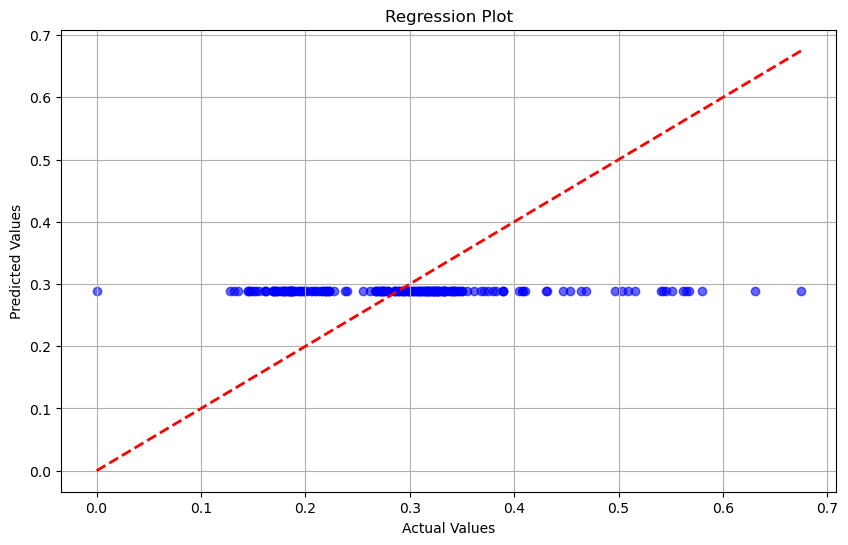

In [126]:
# Regression plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, predictions, alpha=0.6, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
plt.title('Regression Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()
